# Preprocessing

In [998]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch

# Does augmenting classifiers with structured data help?
# Do it for both the baseline classical ML and transformers then compare
# Try it with just structured data [0s and 1s]

In [999]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [1000]:
torch.cuda.is_available()

True

In [1001]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [1002]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


In [1003]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [1004]:
## Investigate K-means clustering to see whether certain medicines have different side effects - use as baseline to see if there is a significant difference with the transformer model
from sklearn.cluster import KMeans

vocabulary=tfidf.get_feature_names_out()
print(vocabulary)

num_clusters=4
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(tfidfSentences)
top_words=km.cluster_centers_.argsort()
print(vocabulary[top_words])
df['cluster']=km.labels_

['00' '04' '06' ... 'zoning' 'zopiclone' 'zyprexa']
[['00' 'paramedics' 'paralyzing' ... 'though' 'feel' 'even']
 ['easliy' 'snowball' 'smptoms' ... 'depression' 'effects' 'side']
 ['00' 'pantry' 'pant' ... 'side' 'effects' 'drug']
 ['kidney' 'nose' 'notable' ... 'day' 'first' 'taking']]


drug_name
cymbalta     1707
effexorxr    1549
lexapro      1492
zoloft       1261
Name: count, dtype: int64
drug_name  cymbalta  effexorxr  lexapro  zoloft
cluster                                        
0                45         45       23      21
1              1326       1192     1178    1012
2                97        122       55      54
3               239        190      236     174


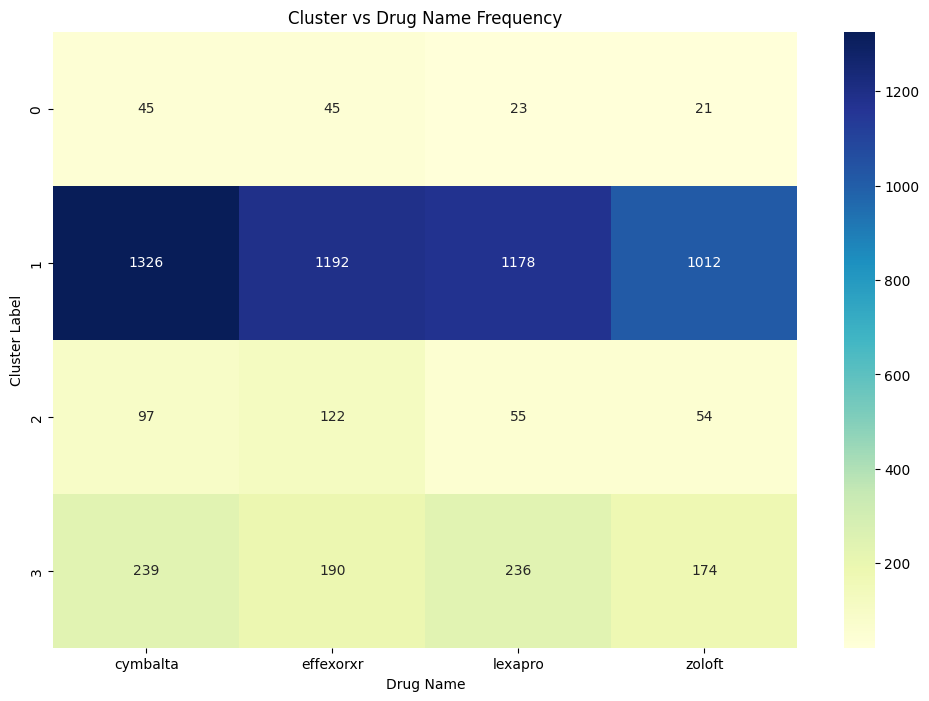

Chi2: 45.95915230961694, p-value: 6.128152407241562e-07


In [1005]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print(df['drug_name'].value_counts())

contingency_table = pd.crosstab(df['cluster'], df['drug_name'])
print(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cluster vs Drug Name Frequency')
plt.ylabel('Cluster Label')
plt.xlabel('Drug Name')
plt.show()

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

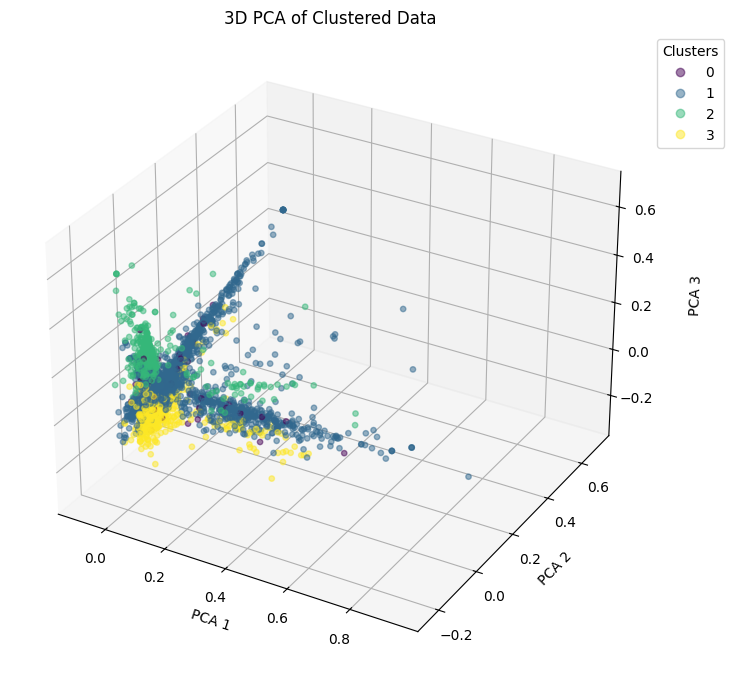

In [1006]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans


pca = PCA(n_components=3)
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=km.labels_, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

ax.zaxis.labelpad = 15

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

legend = ax.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1, 1), title="Clusters")

plt.title('3D PCA of Clustered Data')
plt.show()

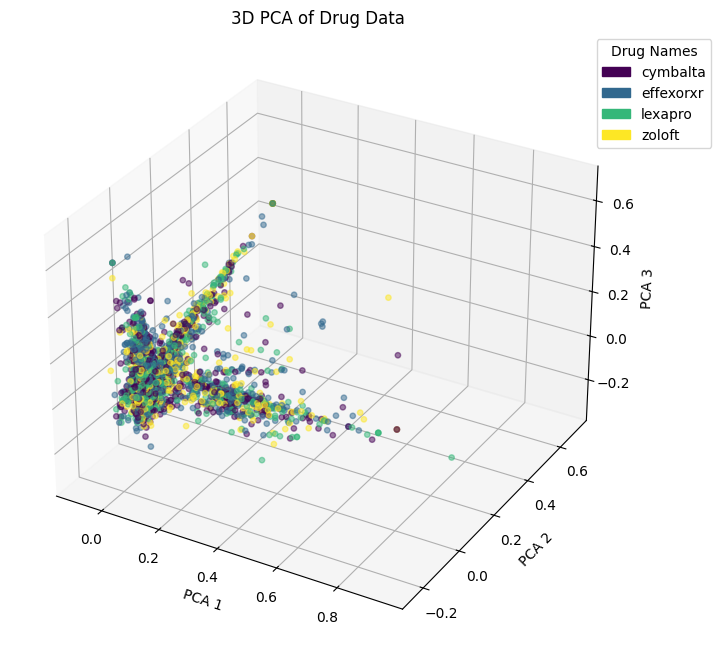

In [1007]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
import numpy as np

label_encoder = LabelEncoder()
drug_labels = label_encoder.fit_transform(df['drug_name'])

pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=drug_labels, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

cmap = plt.cm.viridis

legend_handles = [Patch(color=cmap(norm), label=label) for label, norm in zip(label_encoder.classes_, np.linspace(0, 1, len(label_encoder.classes_)))]
ax.legend(handles=legend_handles, title="Drug Names", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('3D PCA of Drug Data')
plt.show()

# Multi-Label

### Logistic Regression

In [1008]:
## This is just the plain sentences -- Task 1 Feature 1
from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

df_train, df_temp = train_test_split(df, random_state=42, test_size=0.55, shuffle=True)

df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)


x_train = df_train['sentences'].values
y_train = df_train[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_train = np.nan_to_num(y_train, nan=0).astype(int)

x_val = df_valid['sentences'].values
y_val = df_valid[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_val = np.nan_to_num(y_val, nan=0).astype(int)

x_test = df_test['sentences'].values
y_test = df_test[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_test = np.nan_to_num(y_test, nan=0).astype(int)


In [1009]:
# This one uses the drug_name with the sentences -- Task 1 Feature 2

from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')
df['drug_sentences'] = df['drug_name'] + ' ' + df['sentences']

df_train, df_temp = train_test_split(df, random_state=42, test_size=0.55, shuffle=True)

df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)


x_train = df_train['drug_sentences'].values
y_train = df_train[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_train = np.nan_to_num(y_train, nan=0).astype(int)

x_val = df_valid['drug_sentences'].values
y_val = df_valid[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_val = np.nan_to_num(y_val, nan=0).astype(int)

x_test = df_test['drug_sentences'].values
y_test = df_test[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_test = np.nan_to_num(y_test, nan=0).astype(int)


In [1010]:
print('total length=',len(df))
print('%len of training set=',len(x_train)/len(df)*100)
print('%len of validation set=',len(x_val)/len(df)*100)
print('%len of test set=',len(x_test)/len(df)*100)

total length= 6009
%len of training set= 44.99916791479448
%len of validation set= 49.99167914794475
%len of test set= 5.009152937260775


In [1011]:
train_label_counts_0 = [sum(y_train[:, i] == 0) for i in range(y_train.shape[1])]
train_label_counts_1 = [sum(y_train[:, i] == 1) for i in range(y_train.shape[1])]
val_label_counts_0 = [sum(y_val[:, i] == 0) for i in range(y_val.shape[1])]
val_label_counts_1 = [sum(y_val[:, i] == 1) for i in range(y_val.shape[1])]
test_label_counts_0 = [sum(y_test[:, i] == 0) for i in range(y_test.shape[1])]
test_label_counts_1 = [sum(y_test[:, i] == 1) for i in range(y_test.shape[1])]

distribution_df = pd.DataFrame({
    'Label': ['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI'],
    'Train Count (0)': train_label_counts_0,
    'Train Count (1)': train_label_counts_1,
    'Validation Count (0)': val_label_counts_0,
    'Validation Count (1)': val_label_counts_1,
    'Test Count (0)': test_label_counts_0,
    'Test Count (1)': test_label_counts_1
})

# Display the DataFrame
print(distribution_df)


  Label  Train Count (0)  Train Count (1)  Validation Count (0)  \
0   ADR             1712              992                  1936   
1    WD             2507              197                  2781   
2    EF             2188              516                  2488   
3   INF             2548              156                  2836   
4   SSI             2358              346                  2595   
5    DI             2476              228                  2743   

   Validation Count (1)  Test Count (0)  Test Count (1)  
0                  1068             193             108  
1                   223             283              18  
2                   516             246              55  
3                   168             288              13  
4                   409             267              34  
5                   261             274              27  


#### Come here to change prediction variables

In [1012]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
multi_label_y = y_test
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# param_grid = {
#     'estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 
#     'estimator__penalty': ['l1', 'l2'], 
#     'estimator__solver': ['liblinear', 'saga', 'lbfgs'], 
# }

param_grid = {
    'estimator__C': [10], 
    'estimator__penalty': ['l2'], 
    'estimator__solver': ['saga'], 
}

log_reg = LogisticRegression()
multi_target_lr = MultiOutputClassifier(log_reg, n_jobs=-1)
grid_search = GridSearchCV(multi_target_lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfidf, y_train)

print("best param ", grid_search.best_params_)
print("cross val accuracy ", grid_search.best_score_)

# feature2: best param  {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
# feature1: best param  {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(x_test_tfidf)

### adjust and comment out the predictions depending on what feature you are using
######################
# task_1_logistic_f1 = y_test_pred

# task_1_logistic_f2 = y_test_pred
######################
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_micro = f1_score(y_test, y_test_pred, average='micro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_micro = precision_score(y_test, y_test_pred, average='micro')
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_micro = recall_score(y_test, y_test_pred, average='micro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score (Micro): {test_f1_micro:.4f}')
print(f'Test F1 Score (Macro): {test_f1_macro:.4f}')
print(f'Test Precision (Micro): {test_precision_micro:.4f}')
print(f'Test Precision (Macro): {test_precision_macro:.4f}')
print(f'Test Recall (Micro): {test_recall_micro:.4f}')
print(f'Test Recall (Macro): {test_recall_macro:.4f}')
    
class_rep = classification_report(y_test,y_test_pred)
print(class_rep)
for i, label in enumerate(['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']):
    print(f"{label}:")
    #[(tn, fp,
    # fn, tp)]
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    print(f"{cm}")
    
    report = classification_report(y_test[:, i], y_test_pred[:, i], zero_division=1, target_names=["0", "1"])
    print(f"{report}")


best param  {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}
cross val accuracy  0.5773040323132745
Test Accuracy: 0.5249
Test F1 Score (Micro): 0.5308
Test F1 Score (Macro): 0.4719
Test Precision (Micro): 0.6707
Test Precision (Macro): 0.6460
Test Recall (Micro): 0.4392
Test Recall (Macro): 0.3774
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       108
           1       0.44      0.22      0.30        18
           2       0.74      0.36      0.49        55
           3       0.43      0.23      0.30        13
           4       0.86      0.56      0.68        34
           5       0.77      0.37      0.50        27

   micro avg       0.67      0.44      0.53       255
   macro avg       0.65      0.38      0.47       255
weighted avg       0.68      0.44      0.53       255
 samples avg       0.30      0.29      0.29       255

ADR:
[[160  33]
 [ 52  56]]
              precision    recall  f1-score   

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Transformers

In [1013]:
# ## This is just the plain sentences -- Task 1 Feature 1
# from sklearn.model_selection import train_test_split

# df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# newDf=df
# newDf['DI'].fillna(0, inplace=True)
# newDf.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","drug_name"], axis=1, inplace=True)

# # x = df['sentences'].values
# # y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# # y = np.nan_to_num(y, nan=0).astype(int)

# # Split data
# df_train, df_temp = train_test_split(newDf, random_state=42, test_size=0.55, shuffle=True)
# df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)



In [1014]:
print('total length=',len(df))
print('%len of training set=',len(df_train)/len(df)*100)
print('%len of validation set=',len(df_valid)/len(df)*100)
print('%len of test set=',len(df_test)/len(df)*100)

total length= 6009
%len of training set= 44.99916791479448
%len of validation set= 49.99167914794475
%len of test set= 5.009152937260775


In [1015]:
# This one uses the drug_name with the sentences -- Task 1 Feature 2

from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')
newDf=df
newDf['DI'].fillna(0, inplace=True)
newDf['drug_sentences'] = df['drug_name'] + ' ' + df['sentences']
newDf.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","drug_name","sentences"], axis=1, inplace=True)
# x = df['drug_sentences'].values
# y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# y = np.nan_to_num(y, nan=0).astype(int)

# Split data
df_train, df_temp = train_test_split(newDf, random_state=42, test_size=0.55, shuffle=True)
df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)



C:\Users\julev\AppData\Local\Temp\ipykernel_16412\347856079.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  newDf['DI'].fillna(0, inplace=True)


In [1016]:
print(newDf)

      ADR   WD   EF  INF  SSI   DI  cluster  \
0     1.0  0.0  0.0  0.0  0.0  0.0        1   
1     0.0  0.0  0.0  0.0  0.0  0.0        1   
2     0.0  0.0  0.0  0.0  0.0  0.0        1   
3     0.0  0.0  0.0  0.0  0.0  0.0        1   
4     0.0  1.0  0.0  0.0  0.0  0.0        1   
...   ...  ...  ...  ...  ...  ...      ...   
6004  0.0  0.0  0.0  0.0  0.0  0.0        1   
6005  0.0  0.0  0.0  0.0  0.0  0.0        1   
6006  0.0  0.0  0.0  0.0  0.0  0.0        1   
6007  0.0  0.0  1.0  0.0  0.0  0.0        1   
6008  0.0  0.0  1.0  0.0  0.0  0.0        1   

                                         drug_sentences  
0     lexapro extreme weight gain short-term memory ...  
1                              lexapro detoxing lexapro  
2     lexapro slowly cut dosage several months took ...  
3                  lexapro 10 days completely omg rough  
4     lexapro flu-like symptoms dizziness major mood...  
...                                                 ...  
6004                      eff

In [1017]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (2704, 8), Test: (301, 8), Valid: (3004, 8)


In [1018]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [1019]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [1020]:
#df_train['sentences']

In [1021]:
class CustomDatasetTask1(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['drug_sentences'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     
     
class CustomDatasetTask2(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['drug_sentences'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     

In [1022]:
target_list = list(['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI'])
target_list

['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']

In [1023]:
#change this to CustomDatasetTask_ for feature _
train_dataset = CustomDatasetTask2(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDatasetTask2(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDatasetTask2(df_test, tokenizer, MAX_LEN, target_list)

In [1024]:
next(iter(train_dataset))

{'input_ids': tensor([  101,  1062, 12898,  6199,  3635,  5114, 22356,  2606,  3279,  3637,
         16915,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [1025]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
     

In [1026]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [1027]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [1028]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)    

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [1029]:
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [1030]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [1031]:
from collections import defaultdict
import time

torch.cuda.empty_cache()
history = defaultdict(list)
best_accuracy = 0

# model_save_path = './model2_task1_feature1_model(unfrozen)'
start_time = time.time()

# for epoch in range(1, EPOCHS+1):
#     print(f'Epoch {epoch}/{EPOCHS}')
#     model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
#     val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

#     print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)

#     if val_acc > best_accuracy:
#         if not os.path.exists(model_save_path):
#             os.makedirs(model_save_path)
#         torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
#         print(f"Model saved to {model_save_path}")
#         best_accuracy = val_acc
         
# end_time = time.time()
# total_train_time = end_time - start_time

# print(f"Total training time: {total_train_time:.2f} seconds")
# torch.cuda.empty_cache()

In [1032]:
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = (10,7)
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')
# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1])
# plt.grid()

In [1033]:
torch.cuda.empty_cache()

#### Load Models

In [1034]:
import os

# # load feature 1
# model_load_path = './model2_task1_feature1_model(unfrozen)'
# model = BERTClass()
# model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
# model = model.to(device)

# load feature 2
model_load_path = './model2_task1_feature2_model(unfrozen)'
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)


In [1035]:
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [1036]:
test_acc

0.9839424141749723

In [1037]:
from sklearn.metrics import confusion_matrix, classification_report
     
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [1038]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [1039]:
predictions.numpy()


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

#### Come here to change prediction variables

In [1040]:
### adjust and comment out the predictions depending on what feature you are using
######################
# task_1_transformer_f1 = predictions

# task_1_transformer_f2 = predictions
######################


In [1041]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:301 
predictions:torch.Size([301, 6]) 
prediction_probs:torch.Size([301, 6]) 
target_values:torch.Size([301, 6])


In [1042]:
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

         ADR       0.96      0.97      0.97       108
          WD       0.89      0.89      0.89        18
          EF       0.96      0.91      0.93        55
         INF       0.80      0.92      0.86        13
         SSI       0.92      0.97      0.94        34
          DI       1.00      0.89      0.94        27

   micro avg       0.94      0.94      0.94       255
   macro avg       0.92      0.93      0.92       255
weighted avg       0.95      0.94      0.94       255
 samples avg       0.61      0.61      0.61       255



c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [372]:
print(df_test)

                                              sentences  ADR   WD   EF  INF  \
2018  allow think one subject time previous 9,846 th...  0.0  0.0  1.0  0.0   
5762                   since power chair almost nothing  0.0  0.0  0.0  0.0   
5715                         dizziness standing bending  1.0  0.0  0.0  0.0   
1870  started taking 100mg went 50mg due headaches a...  1.0  0.0  0.0  0.0   
5142                            3 weeks stopped working  0.0  0.0  0.0  1.0   
...                                                 ...  ...  ...  ...  ...   
1894                                             sweats  1.0  0.0  0.0  0.0   
2240    zoloft made difference life 'm longer depressed  0.0  0.0  1.0  0.0   
2677                               first week two bliss  0.0  0.0  1.0  0.0   
4411                  currently take 40 mg cymbalta day  0.0  0.0  0.0  0.0   
191                               'm serious pain right  1.0  0.0  0.0  0.0   

      SSI   DI  cluster                            

In [373]:
from sklearn.metrics import multilabel_confusion_matrix
true_test_labels = df_test[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].to_numpy(dtype=np.float32)
print(true_test_labels)

[[0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [374]:
confusion_matrixes=multilabel_confusion_matrix(true_test_labels,predictions.numpy())
class_names = ['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']

for idx, class_name in enumerate(class_names):
    cm = confusion_matrixes[idx]
    print(f"Confusion matrix for class '{class_name}':\n{cm}\n")
    report = classification_report(true_test_labels[:, idx], predictions[:, idx], target_names=[f'{class_name}_0', f'{class_name}_1'])
    print(report)

Confusion matrix for class 'ADR':
[[184   9]
 [  1 107]]

              precision    recall  f1-score   support

       ADR_0       0.99      0.95      0.97       193
       ADR_1       0.92      0.99      0.96       108

    accuracy                           0.97       301
   macro avg       0.96      0.97      0.96       301
weighted avg       0.97      0.97      0.97       301

Confusion matrix for class 'WD':
[[281   2]
 [  3  15]]

              precision    recall  f1-score   support

        WD_0       0.99      0.99      0.99       283
        WD_1       0.88      0.83      0.86        18

    accuracy                           0.98       301
   macro avg       0.94      0.91      0.92       301
weighted avg       0.98      0.98      0.98       301

Confusion matrix for class 'EF':
[[242   4]
 [  5  50]]

              precision    recall  f1-score   support

        EF_0       0.98      0.98      0.98       246
        EF_1       0.93      0.91      0.92        55

    accura

### Statistical Tests

In [670]:
## 4 Total ones
# task_1_transformer_f1, task_1_transformer_f2
# task_1_logistic_f1, task_1_logistic _f2


print(task_1_logistic_f1)
print(task_1_logistic_f2)
print(task_1_transformer_f1)
print(task_1_transformer_f2)



[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
[[1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])


In [877]:
logistic_float_1 = task_1_logistic_f1.astype(float)
transformer_float_1 = task_1_transformer_f1.numpy().astype(float)
logistic_float_2 = task_1_logistic_f2.astype(float)
transformer_float_2 = task_1_transformer_f2.numpy().astype(float)
## multi_label_y is the ground truth
multi_label_y_float = multi_label_y.astype(float)

In [847]:
## Hamming Loss
from sklearn.metrics import hamming_loss

def calculate_hamming_losses(logistic_f1, transformer_f1, logistic_f2, transformer_f2, y_float):
    combinations = [
        ('logistic_1 vs logistic_2', logistic_f1, logistic_f2),
        ('logistic_1 vs transformer_1', logistic_f1, transformer_f1),
        ('logistic_1 vs transformer_2', logistic_f1, transformer_f2),
        ('transformer_1 vs logistic_2', transformer_f1, logistic_f2),
        ('transformer_1 vs transformer_2', transformer_f1, transformer_f2),
        ('logistic_2 vs transformer_2', logistic_f2, transformer_f2),
        ('logistic_1 vs ground truth', logistic_f1, y_float),
        ('transformer_1 vs ground truth', transformer_f1, y_float),
        ('logistic_2 vs ground truth', logistic_f2, y_float),
        ('transformer_2 vs ground truth', transformer_f2, y_float)
    ]
    
    for name, array1, array2 in combinations:
        loss = hamming_loss(array1, array2)
        print(f"Hamming Loss for {name}: {loss}")

# Calculate and print Hamming Losses for all combinations
calculate_hamming_losses(logistic_float_1, transformer_float_1, logistic_float_2, transformer_float_2, multi_label_y_float)

Hamming Loss for logistic_1 vs logistic_2: 0.014396456256921373
Hamming Loss for logistic_1 vs transformer_1: 0.10908084163898117
Hamming Loss for logistic_1 vs transformer_2: 0.10575858250276855
Hamming Loss for transformer_1 vs logistic_2: 0.10243632336655592
Hamming Loss for transformer_1 vs transformer_2: 0.014396456256921373
Hamming Loss for logistic_2 vs transformer_2: 0.10243632336655592
Hamming Loss for logistic_1 vs ground truth: 0.11517165005537099
Hamming Loss for transformer_1 vs ground truth: 0.016057585825027684
Hamming Loss for logistic_2 vs ground truth: 0.10963455149501661
Hamming Loss for transformer_2 vs ground truth: 0.01937984496124031


In [878]:
from scipy.stats import friedmanchisquare
from sklearn.preprocessing import LabelEncoder

def calculate_friedman_multi_label(logistic_f1, transformer_f1, logistic_f2, transformer_f2, true_labels):
    n_labels = true_labels.shape[1]  # Number of labels

    results = []

    for i in range(n_labels):
        label_logistic_f1 = logistic_f1[:, i]
        label_transformer_f1 = transformer_f1[:, i]
        label_logistic_f2 = logistic_f2[:, i]
        label_transformer_f2 = transformer_f2[:, i]
        label_true = true_labels[:, i]

        stat, p = friedmanchisquare(label_logistic_f1, label_transformer_f1, label_logistic_f2, label_transformer_f2, label_true)
        results.append((i, stat, p))
        print(f"Friedman test for label {i}: statistic={stat}, p-value={p}")

    return results

calculate_friedman_multi_label(
    logistic_f1=logistic_float_1,
    transformer_f1=transformer_float_1,
    logistic_f2=logistic_float_2,
    transformer_f2=transformer_float_2,
    true_labels=multi_label_y_float
)
    


Friedman test for label 0: statistic=16.372759856632985, p-value=0.0025576715535565652
Friedman test for label 1: statistic=10.666666666664245, p-value=0.030577016627630297
Friedman test for label 2: statistic=64.68148148148094, p-value=3.0031014251411415e-13
Friedman test for label 3: statistic=12.653061224503691, p-value=0.013101500388329173
Friedman test for label 4: statistic=34.711864406790355, p-value=5.323421579493195e-07
Friedman test for label 5: statistic=27.854545454554025, p-value=1.334881684275001e-05


[(0, 16.372759856632985, 0.0025576715535565652),
 (1, 10.666666666664245, 0.030577016627630297),
 (2, 64.68148148148094, 3.0031014251411415e-13),
 (3, 12.653061224503691, 0.013101500388329173),
 (4, 34.711864406790355, 5.323421579493195e-07),
 (5, 27.854545454554025, 1.334881684275001e-05)]

# Multi-Class

### Logistic Regression

In [1043]:
fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")
    
df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()


Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


In [1044]:
# # feature 1
# from sklearn.model_selection import train_test_split

# # this one has no 0s and 1s as extra features
# df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# df_train, df_temp = train_test_split(df, random_state=42, test_size=0.55, shuffle=True)

# df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)

# x_train = df_train['sentences'].values
# y_train = df_train['drug_name'].values

# x_val = df_valid['sentences'].values
# y_val = df_valid['drug_name'].values

# x_test = df_test['sentences'].values
# y_test = df_test['drug_name'].values

# tfidf_vectorizer = TfidfVectorizer()
# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_val_tfidf = tfidf_vectorizer.transform(x_val)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)


In [1055]:
# # feature 2
# # this one has extra 0s and 1s as extra features
# sentences = df['sentences'].values
# df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# annotation_values = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values

# df_train, df_temp = train_test_split(df, random_state=42, test_size=0.55, shuffle=True)

# df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)

# sentences_train = df_train['sentences'].values
# annotation_values_train = df_train[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# x_train = [
#     sentence + " " + " ".join(map(str, annotation_value)) 
#     for sentence, annotation_value in zip(sentences_train, annotation_values_train)
# ]
# y_train = df_train['drug_name'].values

# sentences_val = df_valid['sentences'].values
# annotation_values_val = df_valid[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# x_val = [
#     sentence + " " + " ".join(map(str, annotation_value)) 
#     for sentence, annotation_value in zip(sentences_val, annotation_values_val)
# ]
# y_val = df_valid['drug_name'].values

# sentences_test = df_test['sentences'].values
# annotation_values_test = df_test[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# x_test = [
#     sentence + " " + " ".join(map(str, annotation_value)) 
#     for sentence, annotation_value in zip(sentences_test, annotation_values_test)
# ]
# y_test = df_test['drug_name'].values

# tfidf_vectorizer = TfidfVectorizer()
# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_val_tfidf = tfidf_vectorizer.transform(x_val)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [1069]:
# feature 3
# this one uses ONLY the annotated values
df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

df_train, df_temp = train_test_split(df, random_state=42, test_size=0.55, shuffle=True)

df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)

x_train = df_train[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_train = df_train['drug_name'].values

x_val = df_valid[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_val = df_valid['drug_name'].values

x_test = df_test[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
y_test = df_test['drug_name'].values

x_train = np.nan_to_num(x_train, nan=0.0)
x_val = np.nan_to_num(x_val, nan=0.0)
x_test = np.nan_to_num(x_test, nan=0.0)


In [1070]:
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100, 1000], 
#     'penalty': ['l1', 'l2'], 
#     'solver': ['liblinear', 'saga', 'lbfgs'], 
# }

#feature1: Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
#feature2:Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
#feature3: Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}

logistic_regression = LogisticRegression(C=0.1,penalty='l1',solver='saga')  # Increased max_iter for convergence
logistic_regression.fit(x_train, y_train) ###### CHANGE HERE FOR DIFFERENT FEATURES (x_train(f1) and x_train_tfidf (f2,f3)) #########
# grid_search = GridSearchCV(estimator=logistic_regression_number, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# grid_search.fit(x_train_number, y_train_number)

best_logistic_regression = logistic_regression

y_test_pred= best_logistic_regression.predict(x_test) ###### CHANGE HERE FOR DIFFERENT FEATURES (x_train(f1) and x_train_tfidf (f2,f3)) #########
test_accuracy_number = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy_number:.4f}')
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.3422
Test Classification Report:
              precision    recall  f1-score   support

    cymbalta       0.32      0.87      0.47        84
   effexorxr       0.45      0.29      0.36        82
     lexapro       0.32      0.08      0.13        72
      zoloft       0.00      0.00      0.00        63

    accuracy                           0.34       301
   macro avg       0.27      0.31      0.24       301
weighted avg       0.29      0.34      0.26       301



c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [780]:
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
y_test_series = pd.Series(y_test)

print("Distribution in training set:")
print(y_train_series.value_counts())
print("Distribution in validation set:")
print(y_val_series.value_counts())
print("Distribution in test set:")
print(y_test_series.value_counts())

Distribution in training set:
cymbalta     791
effexorxr    704
lexapro      644
zoloft       565
Name: count, dtype: int64
Distribution in validation set:
cymbalta     832
lexapro      776
effexorxr    763
zoloft       633
Name: count, dtype: int64
Distribution in test set:
cymbalta     84
effexorxr    82
lexapro      72
zoloft       63
Name: count, dtype: int64


#### Come here to change prediction variables

best param  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
cross_val accuracy  0.31286780310809886
test set
              precision    recall  f1-score   support

    cymbalta       0.32      0.87      0.47        84
   effexorxr       0.46      0.29      0.36        82
     lexapro       0.33      0.08      0.13        72
      zoloft       0.00      0.00      0.00        63

    accuracy                           0.34       301
   macro avg       0.28      0.31      0.24       301
weighted avg       0.29      0.34      0.26       301

[[73  9  1  1]
 [54 24  3  1]
 [58  8  6  0]
 [44 11  8  0]]


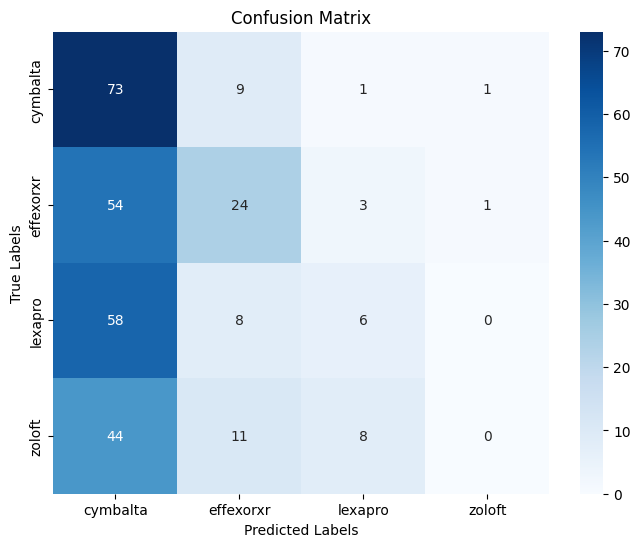

In [1074]:
import matplotlib.pyplot as plt
import seaborn as sns

# tfidf_vectorizer = TfidfVectorizer()
# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
# x_val_tfidf = tfidf_vectorizer.transform(x_val)
# x_test_tfidf = tfidf_vectorizer.transform(x_test)

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'penalty': ['l2'],  
    'solver': ['liblinear'] 
}

logistic_regression_model = LogisticRegression()
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("best param ", grid_search.best_params_)
print("cross_val accuracy ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(x_test)

### adjust and comment out the predictions depending on what feature you are using
######################
# task_2_logistic_f1 = y_test_pred

# task_2_logistic_f2 = y_test_pred

# task_2_logistic_f3 = y_test_pred
######################

print("test set")
print(classification_report(y_test, y_test_pred))
conf = confusion_matrix(y_test, y_test_pred)
print(conf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test_pred))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Transformers

In [1081]:
def transform_labels(row):
    labels = [
        '[POS] adverse drug reaction' if row['ADR'] == 1 else '[NEG] adverse drug reaction',
        '[POS] withdrawal symptom' if row['WD'] == 1 else '[NEG] withdrawal symptom',
        '[POS] effective' if row['EF'] == 1 else '[NEG] effective',
        '[POS] ineffective' if row['INF'] == 1 else '[NEG] ineffective',
        '[POS] sign/symptom/illness' if row['SSI'] == 1 else '[NEG] sign/symptom/illness',
        '[POS] drug indication' if row['DI'] == 1 else '[NEG] drug indication'
    ]
    return ' '.join(labels)

# df['drug_name'] = df['drug_name'].astype('category').cat.codes

In [1082]:
# #this one is for the combined sentences -- Task 2 Feature 1

# df_word_label = df

# df_word_label['transformed_sentences'] = df.apply(lambda row: f"{row['sentences']} {transform_labels(row)}", axis=1)
# #print(df_word_label)

# ## ADR: adverse drug reaction
# ## WD: withdrawal symptom
# ## EF: effective
# ## INF: ineffective
# ## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
# ## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption
# df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","sentences", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1)

# df_word_label = df_word_label[['transformed_sentences', 'drug_name']]

# # Split data
# df_train, df_temp = train_test_split(df_word_label, random_state=42, test_size=0.55, shuffle=True)

# df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)


In [1107]:
# # ## This one is just for the text without transformed sentences -- Task 2 Feature 2
# df_word_label=df

# # x = df_word_label['sentences'].values
# # y = df_word_label['drug_name'].astype('category').cat.codes.values
# df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1)
# df_word_label = df_word_label[['sentences', 'drug_name']]

# # Split data
# df_train, df_temp = train_test_split(df_word_label, random_state=42, test_size=0.55, shuffle=True)

# df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)

In [1131]:
## This one is just for the annotated dataset -- Task 2 Feature 3

df_word_label = df

df_word_label['transformed_labels'] = df_word_label.apply(transform_labels, axis=1)
print(df_word_label['transformed_labels'])

df_word_label.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","sentences", "ADR", "WD", "EF", "INF", "SSI", "DI"], axis=1)
df_word_label = df_word_label[['transformed_labels', 'drug_name']]

# x = df_word_label['transformed_labels'].values
# y = df_word_label['drug_name'].astype('category').cat.codes.values

#Split data
df_train, df_temp = train_test_split(df_word_label, random_state=42, test_size=0.55, shuffle=True)

df_valid, df_test = train_test_split(df_temp, random_state=42, test_size=(1/11), shuffle=True)

0       [POS] adverse drug reaction [NEG] withdrawal s...
1       [NEG] adverse drug reaction [NEG] withdrawal s...
2       [NEG] adverse drug reaction [NEG] withdrawal s...
3       [NEG] adverse drug reaction [NEG] withdrawal s...
4       [NEG] adverse drug reaction [POS] withdrawal s...
                              ...                        
6004    [NEG] adverse drug reaction [NEG] withdrawal s...
6005    [NEG] adverse drug reaction [NEG] withdrawal s...
6006    [NEG] adverse drug reaction [NEG] withdrawal s...
6007    [NEG] adverse drug reaction [NEG] withdrawal s...
6008    [NEG] adverse drug reaction [NEG] withdrawal s...
Name: transformed_labels, Length: 6009, dtype: object


In [1132]:
print(df_word_label)

                                     transformed_labels  drug_name
0     [POS] adverse drug reaction [NEG] withdrawal s...    lexapro
1     [NEG] adverse drug reaction [NEG] withdrawal s...    lexapro
2     [NEG] adverse drug reaction [NEG] withdrawal s...    lexapro
3     [NEG] adverse drug reaction [NEG] withdrawal s...    lexapro
4     [NEG] adverse drug reaction [POS] withdrawal s...    lexapro
...                                                 ...        ...
6004  [NEG] adverse drug reaction [NEG] withdrawal s...  effexorxr
6005  [NEG] adverse drug reaction [NEG] withdrawal s...  effexorxr
6006  [NEG] adverse drug reaction [NEG] withdrawal s...  effexorxr
6007  [NEG] adverse drug reaction [NEG] withdrawal s...  effexorxr
6008  [NEG] adverse drug reaction [NEG] withdrawal s...  effexorxr

[6009 rows x 2 columns]


In [1133]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (2704, 2), Test: (301, 2), Valid: (3004, 2)


In [1134]:
print(df['drug_name'].unique().tolist())

['lexapro', 'zoloft', 'cymbalta', 'effexorxr']


#### come here to change the label df['']

In [1135]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'lexapro':0,
          'zoloft':1,
          'cymbalta':2,
          'effexorxr':3
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['drug_name']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['transformed_labels']]
                                ## change the df[''] depending on the feature
#transformed_sentences, sentences, transformed_labels - f1, f2, and f3
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [1136]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [1137]:
from torch.optim import Adam
from tqdm import tqdm

In [1138]:


history = defaultdict(list)
torch.cuda.empty_cache()
# def train(model, train_data, val_data, learning_rate, epochs, model_save_path):

#     train, val = Dataset(train_data), Dataset(val_data)

#     train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
#     val_dataloader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True)

#     use_cuda = torch.cuda.is_available()
#     device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#     criterion = nn.CrossEntropyLoss()
#     optimizer = Adam(model.parameters(), lr=learning_rate)

#     if use_cuda:
#         model = model.cuda()
#         criterion = criterion.cuda()
#     best_accuracy = 0

#     start_time = time.time()

#     for epoch_num in range(epochs):

#         total_acc_train = 0
#         total_loss_train = 0

#         for train_input, train_label in tqdm(train_dataloader):

#             train_label = train_label.to(device)
#             mask = train_input['attention_mask'].to(device)
#             input_id = train_input['input_ids'].squeeze(1).to(device)

#             output = model(input_id, mask)
            
#             batch_loss = criterion(output, train_label.long())
#             total_loss_train += batch_loss.item()
            
#             acc = (output.argmax(dim=1) == train_label).sum().item()
#             total_acc_train += acc

#             model.zero_grad()
#             batch_loss.backward()
#             optimizer.step()
        
#         total_acc_val = 0
#         total_loss_val = 0

#         with torch.no_grad():

#             for val_input, val_label in val_dataloader:

#                 val_label = val_label.to(device)
#                 mask = val_input['attention_mask'].to(device)
#                 input_id = val_input['input_ids'].squeeze(1).to(device)

#                 output = model(input_id, mask)

#                 batch_loss = criterion(output, val_label.long())
#                 total_loss_val += batch_loss.item()
                
#                 acc = (output.argmax(dim=1) == val_label).sum().item()
#                 total_acc_val += acc
        
#         train_acc = total_acc_train / len(train_data)
#         train_loss = total_loss_train / len(train_data)
#         val_acc = total_acc_val / len(val_data)
#         val_loss = total_loss_val / len(val_data)

#         history['train_acc'].append(train_acc)
#         history['train_loss'].append(train_loss)
#         history['val_acc'].append(val_acc)
#         history['val_loss'].append(val_loss)

#         if val_acc > best_accuracy:
#             if not os.path.exists(model_save_path):
#                 os.makedirs(model_save_path)
#             torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
#             print(f"Model saved to {model_save_path}")
#             best_accuracy = val_acc
        
#         print(f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} | Train Accuracy: {train_acc: .3f} | Val Loss: {val_loss: .3f} | Val Accuracy: {val_acc: .3f}')

#     end_time = time.time()
#     total_train_time = end_time - start_time

#     print(f"Total training time: {total_train_time:.2f} seconds")
#     torch.cuda.empty_cache()
#     return history

EPOCHS = 15
model = BertClassifier()
LR = 1e-6
# model_save_path = './model2_task2_feature1_model(unfrozen)'

# train(model, df_train, df_valid, LR, EPOCHS, model_save_path)
# torch.cuda.empty_cache()

In [1139]:
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = (10,7)
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')
# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1])
# plt.grid()

#### Load models

In [1140]:
# feature 1 model
# model_load_path = './model2_task2_feature1_model(unfrozen)'
# model_save_path = model_load_path
# model = BertClassifier()
# model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
# model = model.to(device)

# # # feature 2 model
# model_load_path = './model2_task2_feature2_model(unfrozen)'
# model_save_path = model_load_path
# model = BertClassifier()
# model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
# model = model.to(device)

# feature 3 model
model_load_path = './model2_task2_feature3_model(unfrozen)'
model_save_path = model_load_path
model = BertClassifier()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)

In [1141]:
test_data_loader = torch.utils.data.DataLoader(df_test, batch_size=8, shuffle=False)

In [1142]:
torch.cuda.empty_cache()
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    total_acc_test = 0
    total_loss_test = 0
    model.eval()

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader, desc="Evaluating"):
            test_label = test_label.to(device, dtype=torch.long)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            loss = criterion(output, test_label)
            total_loss_test += loss.item()

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    avg_loss_test = total_loss_test / len(test_dataloader)
    avg_acc_test = total_acc_test / len(test_data)

    print(f'Test Loss: {avg_loss_test:.3f} | Test Accuracy: {avg_acc_test:.3f}')
evaluate(model, df_test)

# labels = {'lexapro':0,
#           'zoloft':1,
#           'cymbalta':2,
#           'effexorxr':3
#           }

Evaluating: 100%|██████████| 151/151 [00:04<00:00, 30.95it/s]

Test Loss: 1.377 | Test Accuracy: 0.322


In [1143]:
from torch.utils.data import DataLoader

def get_prediction(model, dataloader):
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda') if use_cuda else torch.device('cpu')

    if use_cuda:
        model = model.cuda()

    model.eval()

    predictions = []
    true_labels = []

    with torch.no_grad():
        for data_input, data_label in tqdm(dataloader):
            data_label = data_label.to(device)
            mask = data_input['attention_mask'].squeeze(1).to(device)
            input_id = data_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            preds = output.argmax(dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(data_label.cpu().numpy())

    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    return predictions, true_labels

test_dataset = Dataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

model.load_state_dict(torch.load(os.path.join(model_save_path, 'model_state.bin')))

predictions, true_labels = get_prediction(model, test_dataloader)

from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions))

100%|██████████| 151/151 [00:04<00:00, 32.88it/s]

              precision    recall  f1-score   support

           0       0.27      0.64      0.38        72
           1       0.00      0.00      0.00        63
           2       0.33      0.45      0.38        84
           3       0.72      0.16      0.26        82

    accuracy                           0.32       301
   macro avg       0.33      0.31      0.26       301
weighted avg       0.35      0.32      0.27       301




c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Come here to change prediction variables

In [1154]:
# labels = {'lexapro':0,
#           'zoloft':1,
#           'cymbalta':2,
#           'effexorxr':3
#           }

reverse_labels = {v: k for k, v in labels.items()}

vectorized_reverse_labels = np.vectorize(reverse_labels.get)
label_predictions = np.array(vectorized_reverse_labels(predictions))

print(label_predictions)

### adjust and comment out the predictions depending on what feature you are using
######################
# task_2_transformer_f1 = label_predictions

# task_2_transformer_f2  = label_predictions

# task_2_transformer_f3  = label_predictions
######################

['lexapro' 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'cymbalta' 'lexapro'
 'cymbalta' 'cymbalta' 'lexapro' 'cymbalta' 'lexapro' 'lexapro'
 'effexorxr' 'lexapro' 'lexapro' 'lexapro' 'cymbalta' 'cymbalta'
 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'cymbalta' 'lexapro' 'lexapro'
 'cymbalta' 'cymbalta' 'cymbalta' 'lexapro' 'lexapro' 'lexapro' 'cymbalta'
 'lexapro' 'lexapro' 'cymbalta' 'cymbalta' 'lexapro' 'lexapro' 'lexapro'
 'lexapro' 'lexapro' 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'cymbalta'
 'lexapro' 'lexapro' 'lexapro' 'lexapro' 'lexapro' 'lexapro' 'effexorxr'
 'lexapro' 'cymbalta' 'lexapro' 'lexapro' 'lexapro' 'cymbalta' 'lexapro'
 'cymbalta' 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'effexorxr'
 'lexapro' 'lexapro' 'cymbalta' 'lexapro' 'effexorxr' 'lexapro' 'lexapro'
 'lexapro' 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'cymbalta' 'lexapro'
 'cymbalta' 'lexapro' 'lexapro' 'cymbalta' 'lexapro' 'cymbalta' 'cymbalta'
 'cymbalta' 'lexapro' 'cymbalta' 'lexapro' 'lexapro' 'lexapro' 'cy

In [1155]:
true_numpy_labels=np.array(df_test['drug_name'].to_numpy())
print(true_numpy_labels)

['zoloft' 'effexorxr' 'effexorxr' 'zoloft' 'effexorxr' 'zoloft'
 'effexorxr' 'effexorxr' 'effexorxr' 'lexapro' 'lexapro' 'lexapro'
 'lexapro' 'effexorxr' 'cymbalta' 'effexorxr' 'cymbalta' 'cymbalta'
 'cymbalta' 'zoloft' 'cymbalta' 'zoloft' 'cymbalta' 'cymbalta' 'lexapro'
 'effexorxr' 'zoloft' 'cymbalta' 'cymbalta' 'cymbalta' 'cymbalta'
 'lexapro' 'lexapro' 'zoloft' 'lexapro' 'effexorxr' 'lexapro' 'zoloft'
 'zoloft' 'effexorxr' 'cymbalta' 'effexorxr' 'lexapro' 'cymbalta'
 'lexapro' 'effexorxr' 'cymbalta' 'lexapro' 'cymbalta' 'cymbalta'
 'lexapro' 'lexapro' 'lexapro' 'cymbalta' 'lexapro' 'zoloft' 'lexapro'
 'effexorxr' 'cymbalta' 'effexorxr' 'zoloft' 'cymbalta' 'effexorxr'
 'zoloft' 'lexapro' 'cymbalta' 'cymbalta' 'effexorxr' 'lexapro'
 'effexorxr' 'lexapro' 'effexorxr' 'effexorxr' 'lexapro' 'zoloft'
 'effexorxr' 'zoloft' 'zoloft' 'effexorxr' 'zoloft' 'cymbalta' 'cymbalta'
 'cymbalta' 'effexorxr' 'effexorxr' 'cymbalta' 'effexorxr' 'cymbalta'
 'zoloft' 'zoloft' 'effexorxr' 'effexorxr' 'cy

In [1156]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
text_labels = ["zoloft", "effexorxr", "lexapro", "cymbalta"]

mlb = MultiLabelBinarizer(classes=text_labels)
true_binary_labels = mlb.fit_transform([[label] for label in true_numpy_labels])
pred_binary_labels = mlb.transform([[label] for label in label_predictions])

# Compute multilabel confusion matrix for all classes
confusion_matrices = multilabel_confusion_matrix(true_binary_labels, pred_binary_labels)
# print(confusion_matrices)

# Iterate over each class
for idx, class_name in enumerate(labels):
    # Get the confusion matrix for the current class
    cm = confusion_matrices[idx]
    print(f"Confusion matrix for class '{class_name}':\n{cm}\n")
    
    # Generate classification report for the current class
    report = classification_report(true_binary_labels[:, idx], pred_binary_labels[:, idx],
                                   target_names=[f'{class_name}_0', f'{class_name}_1'])
    print(report)

Confusion matrix for class 'lexapro':
[[238   0]
 [ 63   0]]

              precision    recall  f1-score   support

   lexapro_0       0.79      1.00      0.88       238
   lexapro_1       0.00      0.00      0.00        63

    accuracy                           0.79       301
   macro avg       0.40      0.50      0.44       301
weighted avg       0.63      0.79      0.70       301

Confusion matrix for class 'zoloft':
[[214   5]
 [ 69  13]]

              precision    recall  f1-score   support

    zoloft_0       0.76      0.98      0.85       219
    zoloft_1       0.72      0.16      0.26        82

    accuracy                           0.75       301
   macro avg       0.74      0.57      0.56       301
weighted avg       0.75      0.75      0.69       301

Confusion matrix for class 'cymbalta':
[[107 122]
 [ 26  46]]

              precision    recall  f1-score   support

  cymbalta_0       0.80      0.47      0.59       229
  cymbalta_1       0.27      0.64      0.38        

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1157]:
from sklearn.metrics import confusion_matrix

all_confusion_matrix=confusion_matrix(np.array(true_numpy_labels), np.array(label_predictions))

[[38  3 43  0]
 [30 13 39  0]
 [25  1 46  0]
 [22  1 40  0]]


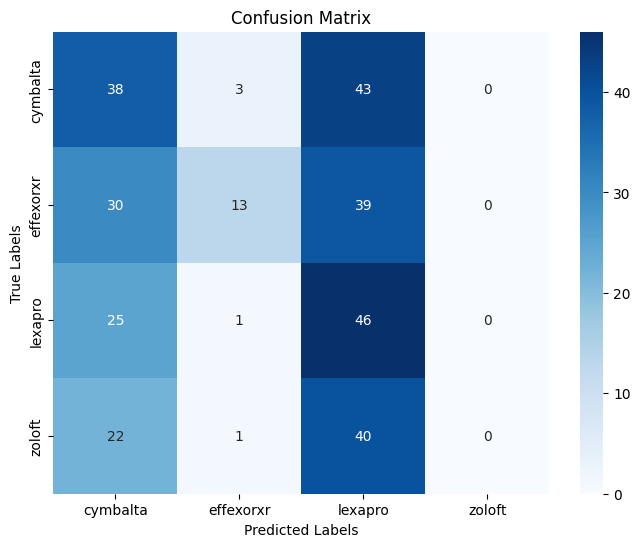

In [1158]:
import matplotlib.pyplot as plt
import seaborn as sns

print(all_confusion_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(all_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_numpy_labels), yticklabels=np.unique(true_numpy_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Statistical Tests

In [1159]:
## 6 Total ones
# task_2_transformer_f1, task_2_transformer_f2, task_2_transformer_f3
# task_2_logistic_f1, task_2_logistic _f2, task_2_logistic_f3

print(true_numpy_labels)

# print(task_2_logistic_f1)
# print(task_2_transformer_f1)
# print(task_2_logistic_f2)
print(task_2_transformer_f2)
# print(task_2_logistic_f3)
# print(task_2_transformer_f3)

['zoloft' 'effexorxr' 'effexorxr' 'zoloft' 'effexorxr' 'zoloft'
 'effexorxr' 'effexorxr' 'effexorxr' 'lexapro' 'lexapro' 'lexapro'
 'lexapro' 'effexorxr' 'cymbalta' 'effexorxr' 'cymbalta' 'cymbalta'
 'cymbalta' 'zoloft' 'cymbalta' 'zoloft' 'cymbalta' 'cymbalta' 'lexapro'
 'effexorxr' 'zoloft' 'cymbalta' 'cymbalta' 'cymbalta' 'cymbalta'
 'lexapro' 'lexapro' 'zoloft' 'lexapro' 'effexorxr' 'lexapro' 'zoloft'
 'zoloft' 'effexorxr' 'cymbalta' 'effexorxr' 'lexapro' 'cymbalta'
 'lexapro' 'effexorxr' 'cymbalta' 'lexapro' 'cymbalta' 'cymbalta'
 'lexapro' 'lexapro' 'lexapro' 'cymbalta' 'lexapro' 'zoloft' 'lexapro'
 'effexorxr' 'cymbalta' 'effexorxr' 'zoloft' 'cymbalta' 'effexorxr'
 'zoloft' 'lexapro' 'cymbalta' 'cymbalta' 'effexorxr' 'lexapro'
 'effexorxr' 'lexapro' 'effexorxr' 'effexorxr' 'lexapro' 'zoloft'
 'effexorxr' 'zoloft' 'zoloft' 'effexorxr' 'zoloft' 'cymbalta' 'cymbalta'
 'cymbalta' 'effexorxr' 'effexorxr' 'cymbalta' 'effexorxr' 'cymbalta'
 'zoloft' 'zoloft' 'effexorxr' 'effexorxr' 'cy

In [1160]:
from sklearn.metrics import cohen_kappa_score

def calculate_cohen_kappa_scores(logistic_f1, transformer_f1, logistic_f2, transformer_f2, logistic_f3, transformer_f3, true_labels):
    combinations = [
        ('logistic_1 vs logistic_2', logistic_f1, logistic_f2),
        ('logistic_1 vs logistic_3', logistic_f1, logistic_f3),
        ('logistic_2 vs logistic_3', logistic_f2, logistic_f3),
        ('transformer_1 vs transformer_2', transformer_f1, transformer_f2),
        ('transformer_1 vs transformer_3', transformer_f1, transformer_f3),
        ('transformer_2 vs transformer_3', transformer_f2, transformer_f3),
        ('logistic_1 vs transformer_1', logistic_f1, transformer_f1),
        ('logistic_1 vs transformer_2', logistic_f1, transformer_f2),
        ('logistic_1 vs transformer_3', logistic_f1, transformer_f3),
        ('logistic_2 vs transformer_1', logistic_f2, transformer_f1),
        ('logistic_2 vs transformer_2', logistic_f2, transformer_f2),
        ('logistic_2 vs transformer_3', logistic_f2, transformer_f3),
        ('logistic_3 vs transformer_1', logistic_f3, transformer_f1),
        ('logistic_3 vs transformer_2', logistic_f3, transformer_f2),
        ('logistic_3 vs transformer_3', logistic_f3, transformer_f3),
        ('logistic_1 vs ground truth', logistic_f1, true_labels),
        ('logistic_2 vs ground truth', logistic_f2, true_labels),
        ('logistic_3 vs ground truth', logistic_f3, true_labels),
        ('transformer_1 vs ground truth', transformer_f1, true_labels),
        ('transformer_2 vs ground truth', transformer_f2, true_labels),
        ('transformer_3 vs ground truth', transformer_f3, true_labels)
    ]
    
    for name, array1, array2 in combinations:
        score = cohen_kappa_score(array1, array2)
        print(f"Cohen's Kappa Score for {name}: {score}")

calculate_cohen_kappa_scores(
    logistic_f1=task_2_logistic_f1,
    transformer_f1=task_2_transformer_f1,
    logistic_f2=task_2_logistic_f2,
    transformer_f2=task_2_transformer_f2,
    logistic_f3=task_2_logistic_f3,
    transformer_f3=task_2_transformer_f3,
    true_labels=true_numpy_labels
)


Cohen's Kappa Score for logistic_1 vs logistic_2: 0.9907771973097605
Cohen's Kappa Score for logistic_1 vs logistic_3: 0.0921565053113036
Cohen's Kappa Score for logistic_2 vs logistic_3: 0.08796989977691205
Cohen's Kappa Score for transformer_1 vs transformer_2: -0.011594689968072558
Cohen's Kappa Score for transformer_1 vs transformer_3: 0.3870595919621932
Cohen's Kappa Score for transformer_2 vs transformer_3: -0.04598585262001231
Cohen's Kappa Score for logistic_1 vs transformer_1: 0.018608349900596455
Cohen's Kappa Score for logistic_1 vs transformer_2: 0.0029711978618749413
Cohen's Kappa Score for logistic_1 vs transformer_3: 0.06310512532734758
Cohen's Kappa Score for logistic_2 vs transformer_1: 0.015256698744035457
Cohen's Kappa Score for logistic_2 vs transformer_2: 0.005995237825273558
Cohen's Kappa Score for logistic_2 vs transformer_3: 0.0612367300425839
Cohen's Kappa Score for logistic_3 vs transformer_1: 0.33626538722496857
Cohen's Kappa Score for logistic_3 vs transform

In [1161]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(true_numpy_labels,task_2_transformer_f1)

0.06650903780616059

In [1164]:

from sklearn.preprocessing import LabelEncoder

all_words = task_2_logistic_f1 + task_2_transformer_f1 + task_2_logistic_f2 + task_2_transformer_f2 + task_2_logistic_f3 + task_2_transformer_f3 + true_numpy_labels

model = LabelEncoder()

model.fit(all_words)

def words_to_numeric(words, encoder):
    return encoder.transform(words)



logistic_f1_vectors = words_to_numeric(task_2_logistic_f1, label_encoder)
transformer_f1_vectors = words_to_numeric(task_2_transformer_f1, label_encoder)
logistic_f2_vectors = words_to_numeric(task_2_logistic_f2, label_encoder)
transformer_f2_vectors = words_to_numeric(task_2_transformer_f2, label_encoder)
logistic_f3_vectors = words_to_numeric(task_2_logistic_f3, label_encoder)
transformer_f3_vectors = words_to_numeric(task_2_transformer_f3, label_encoder)
true_label_vectors = words_to_numeric(true_numpy_labels, label_encoder)


In [1165]:
def calculate_mcc_scores(logistic_f1, transformer_f1, logistic_f2, transformer_f2, logistic_f3, transformer_f3, true_labels):
    combinations = [
        ('logistic_1 vs logistic_2', logistic_f1, logistic_f2),
        ('logistic_1 vs logistic_3', logistic_f1, logistic_f3),
        ('logistic_2 vs logistic_3', logistic_f2, logistic_f3),
        ('transformer_1 vs transformer_2', transformer_f1, transformer_f2),
        ('transformer_1 vs transformer_3', transformer_f1, transformer_f3),
        ('transformer_2 vs transformer_3', transformer_f2, transformer_f3),
        ('logistic_1 vs transformer_1', logistic_f1, transformer_f1),
        ('logistic_1 vs transformer_2', logistic_f1, transformer_f2),
        ('logistic_1 vs transformer_3', logistic_f1, transformer_f3),
        ('logistic_2 vs transformer_1', logistic_f2, transformer_f1),
        ('logistic_2 vs transformer_2', logistic_f2, transformer_f2),
        ('logistic_2 vs transformer_3', logistic_f2, transformer_f3),
        ('logistic_3 vs transformer_1', logistic_f3, transformer_f1),
        ('logistic_3 vs transformer_2', logistic_f3, transformer_f2),
        ('logistic_3 vs transformer_3', logistic_f3, transformer_f3),
        ('logistic_1 vs ground truth', logistic_f1, true_labels),
        ('logistic_2 vs ground truth', logistic_f2, true_labels),
        ('logistic_3 vs ground truth', logistic_f3, true_labels),
        ('transformer_1 vs ground truth', transformer_f1, true_labels),
        ('transformer_2 vs ground truth', transformer_f2, true_labels),
        ('transformer_3 vs ground truth', transformer_f3, true_labels)
    ]
    
    for name, array1, array2 in combinations:
        stat= matthews_corrcoef(array1, array2)
        print(f"Matthews Correlation Coefficient for {name}: {stat}")

calculate_mcc_scores(
    logistic_f1=logistic_f1_vectors,
    transformer_f1=transformer_f1_vectors,
    logistic_f2=logistic_f2_vectors,
    transformer_f2=transformer_f2_vectors,
    logistic_f3=logistic_f3_vectors,
    transformer_f3=transformer_f3_vectors,
    true_labels=true_label_vectors
)

Matthews Correlation Coefficient for logistic_1 vs logistic_2: 0.9908243011149059
Matthews Correlation Coefficient for logistic_1 vs logistic_3: 0.11603360836444948
Matthews Correlation Coefficient for logistic_2 vs logistic_3: 0.11044995801961668
Matthews Correlation Coefficient for transformer_1 vs transformer_2: -0.01661564829025215
Matthews Correlation Coefficient for transformer_1 vs transformer_3: 0.4551360657179037
Matthews Correlation Coefficient for transformer_2 vs transformer_3: -0.06644812326256089
Matthews Correlation Coefficient for logistic_1 vs transformer_1: 0.02283953478105437
Matthews Correlation Coefficient for logistic_1 vs transformer_2: 0.0035845582243071495
Matthews Correlation Coefficient for logistic_1 vs transformer_3: 0.0746322866284426
Matthews Correlation Coefficient for logistic_2 vs transformer_1: 0.018695243554601594
Matthews Correlation Coefficient for logistic_2 vs transformer_2: 0.007267776505058765
Matthews Correlation Coefficient for logistic_2 vs 